# Proyecto Modelación y Simulación

    - Francis Aguilar 22243
    - Diego García    22404
    - Ángela García   22869

Usando un modelo basado en agentes, sobre una red sintética, se simulará el crecimiento y el colapso de una estafa piramidal, impulsada por el reclutamiento. Cada agente debería invertir o reclutar según su credibilidad y éxito local.

In [130]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [131]:
# params = {
#     "N_AGENTES": 500,
#     "GRADO_MEDIO": 3,
#     "NUM_PROMOTORES_INICIALES": 3,
#     "INVERSION": 100.0,
#     "RETORNO": 0.05,
#     "COMISION": 0.20,
#     "P_BASE": 0.25,
#     "PASOS_MAX": 100,
#     "PASOS_SIN_NUEVOS_PARA_COLAPSO": 8
# }

In [132]:
# Reproducibilidad
random.seed(42)
np.random.seed(42)

# Parámetros
params = {
    "N_AGENTES": 500,                          # Cantidad de agentes
    "GRADO_MEDIO": 3,                          # Conectividad de la red
    "NUM_PROMOTORES_INICIALES": 3,
    "INVERSION": 100.0,                        # Monto que invierte cada nuevo participante
    "RETORNO": 0.05,                           # Retorno prometido por periodo, según lo invertido
    "COMISION": 0.20,                          # Comisión para el reclutador, según la inversión del reclutado
    "P_BASE": 0.25,                            # Probabilidad inicial de convencer a otro
    "PASOS_MAX": 100,                          # Paso máximo de simulación
    "PASOS_SIN_NUEVOS_PARA_COLAPSO": 8,        # Cuántos pasos sin nuevos tonotos que se metan a la estafa para que colapse
    "LAG_PROMOTOR_VETERANO": 3,                # Pasos para ser "veterano"
    "MIN_FRACCION_PARTICIPANTES_PAGADOS": 0.3  # Porcentaje mínimo de participantes pagados para evitar colapso
}

In [133]:
def crear_red():
    # Crear la red sintética
    G = nx.barabasi_albert_graph(
        n=params["N_AGENTES"],
        m=params["GRADO_MEDIO"]
    )

    # Inicializar atributos de los agentes
    for n in G.nodes:
        G.nodes[n].update({
            "estado": "ignorante",      # "ignorante", "participante", "promotor"
            "credibilidad": np.random.uniform(0.2, 0.8),
            "invertido": 0.0,
            "ganancia": 0.0,            # ganancia neta
            "reclutados": 0,            # número de agentes que ha reclutado
            "paso_union": None,         # en qué paso entró a la estafa
            "reclutador": None          # quién lo reclutó
        })

    # Escoger promotores iniciales de entre los agentes
    promotores_iniciales = random.sample(list(G.nodes), params["NUM_PROMOTORES_INICIALES"])

    for p in promotores_iniciales:
        G.nodes[p]["estado"] = "promotor"
        # El promotor inicial invierte para "activar" la estafa
        G.nodes[p]["invertido"] = params["INVERSION"]
        G.nodes[p]["ganancia"] = -params["INVERSION"]
        G.nodes[p]["paso_union"] = 0

    # Estado global de la estafa
    state = {
        "t": 0,
        "colapsado": False
    }

    # Historial para análisis
    history = {
        "t": [],
        "n_participantes": [],
        "n_promotores": [],
        "n_promotores_veteranos": [],
        "n_participantes_normales": [],
        "n_nuevos": [],
        "total_invertido": [],
        "ganancia_total": [],
        "colapsado": []
    }
    return G, state, history

G, state, history = crear_red()


In [134]:
# Metricas globales de cada paso
def registrar_estado():
    t = state["t"]

    # Participantes = todos los que están dentro de la estafa (participante o promotor)
    participantes = [
        n for n, a in G.nodes(data=True)
        if a["estado"] in ("participante", "promotor")
    ]

    # Promotores totales
    promotores = [
        n for n, a in G.nodes(data=True)
        if a["estado"] == "promotor"
    ]
    n_promotores = len(promotores)

    # Promotores veteranos
    veteranos = [
        n for n in promotores
        if G.nodes[n]["paso_union"] is not None
        and G.nodes[n]["paso_union"] <= t - params["LAG_PROMOTOR_VETERANO"]
    ]
    n_promotores_veteranos = len(veteranos)

    # Participantes "normales" (no promotores)
    n_participantes_normales = sum(
        1 for _, a in G.nodes(data=True)
        if a["estado"] == "participante"
    )

    total_invertido = sum(a["invertido"] for _, a in G.nodes(data=True))
    ganancia_total = sum(a["ganancia"] for _, a in G.nodes(data=True))

    history["t"].append(t)
    history["n_participantes"].append(len(participantes))
    history["n_promotores"].append(n_promotores)
    history["n_promotores_veteranos"].append(n_promotores_veteranos)
    history["n_participantes_normales"].append(n_participantes_normales)
    history["n_nuevos"].append(0)  # se sobrescribe en cada step()
    history["total_invertido"].append(total_invertido)
    history["ganancia_total"].append(ganancia_total)
    history["colapsado"].append(state["colapsado"])

# Registrar el estado inicial (t = 0)
registrar_estado()

In [135]:
# Probabilidad de reclutamiento
# Depende de la credibilidad del promotor y del éxito local
def prob_reclutamiento(promotor, vecino):
    a = G.nodes[promotor]
    vecinos_promotor = list(G.neighbors(promotor))
    exito_local = a["reclutados"] / max(1, len(vecinos_promotor))

    # Mezclamos factores: base * (1 + credibilidad) * (0.5 + éxito_local)
    p = params["P_BASE"] * (0.5 + a["credibilidad"]) * (0.5 + exito_local)
    return float(np.clip(p, 0.0, 1.0))

# Todo lo que ocurre en un paso de la simulación
def step():
    if state["colapsado"]:
        return  # No hacer nada si ya colapsó

    t = state["t"]
    nuevos = []

    # 1. Reclutamiento: cada promotor intenta convencer a vecinos ignorantes
    promotores = [n for n, a in G.nodes(data=True) if a["estado"] == "promotor"]

    for p in promotores:
        vecinos = list(G.neighbors(p))
        candidatos = [v for v in vecinos if G.nodes[v]["estado"] == "ignorante"]
        if not candidatos:
            continue

        for v in candidatos:
            p_recl = prob_reclutamiento(p, v)
            if np.random.rand() < p_recl:
                # El reclutado invierte
                G.nodes[v]["estado"] = "participante"
                inversion_v = np.random.normal(params["INVERSION"], params["INVERSION"] * 0.2)
                inversion_v = max(10, inversion_v)  # evita inversiones negativas o muy pequeñas
                G.nodes[v]["invertido"] = inversion_v
                G.nodes[v]["ganancia"] = -inversion_v
                G.nodes[v]["paso_union"] = t
                G.nodes[v]["reclutador"] = p
                nuevos.append(v)

                # Le da comisión al promotor
                G.nodes[p]["ganancia"] += params["COMISION"] * params["INVERSION"]
                G.nodes[p]["reclutados"] += 1

        # 2. Nuevos pagan a viejos,
        # priorizando promotores veteranos y un % mínimo de participantes.
        inversion_nueva = len(nuevos) * params["INVERSION"]

        participantes_previos = [
            n for n, a in G.nodes(data=True)
            if a["estado"] in ("participante", "promotor")
            and a["paso_union"] is not None
            and a["paso_union"] < t
        ]

        if participantes_previos and inversion_nueva > 0:
            # Separar promotores veteranos y resto de participantes
            veteranos = [
                n for n in participantes_previos
                if G.nodes[n]["estado"] == "promotor"
                and G.nodes[n]["paso_union"] <= t - params["LAG_PROMOTOR_VETERANO"]
            ]
            otros = [n for n in participantes_previos if n not in veteranos]

            pool = inversion_nueva  # dinero disponible para pagar retornos

            # ---- 2.1 Pagar primero a promotores veteranos (completo) ----
            costo_veteranos = params["RETORNO"] * sum(G.nodes[n]["invertido"] for n in veteranos)

            if costo_veteranos > 0:
                if pool >= costo_veteranos:
                    for n in veteranos:
                        inv = G.nodes[n]["invertido"]
                        pago = params["RETORNO"] * inv
                        G.nodes[n]["ganancia"] += pago
                    pool -= costo_veteranos
                else:
                    # ni siquiera alcanza para ellos → colapso
                    state["colapsado"] = True

            # ---- 2.2 Pagar a un porcentaje mínimo de los demás participantes ----
            if not state["colapsado"] and otros:
                n_otros = len(otros)
                n_min = int(np.ceil(params["MIN_FRACCION_PARTICIPANTES_PAGADOS"] * n_otros))

                # costo individual del retorno completo de cada uno
                otros_costos = [
                    (n, params["RETORNO"] * G.nodes[n]["invertido"])
                    for n in otros
                ]

                # Priorizar a los más antiguos
                otros_costos.sort(key=lambda x: G.nodes[x[0]]["paso_union"])

                pagados = []
                for n, costo in otros_costos:
                    if pool >= costo:
                        G.nodes[n]["ganancia"] += costo
                        pool -= costo
                        pagados.append(n)
                    else:
                        break

                # si no se logró pagar al porcentaje mínimo → colapso
                if len(pagados) < n_min:
                    state["colapsado"] = True


    # 3. Algunos participantes "exitosos" se vuelven promotores
    # El exito se mide por ganancia positiva y credibilidad alta
    if not state["colapsado"]:
        for n, a in G.nodes(data=True):
            if a["estado"] == "participante" and a["ganancia"] > 0 and a["credibilidad"] > 0.5:
                a["estado"] = "promotor"


    

    # 4. Actualizar credibilidad de promotores según si les va bien o mal
    for n, a in G.nodes(data=True):
        if a["estado"] == "promotor":
            if a["ganancia"] > 0 and len(nuevos) > 0 and not state["colapsado"]:
                a["credibilidad"] = min(1.0, a["credibilidad"] + 0.05)
            else:
                a["credibilidad"] = max(0.0, a["credibilidad"] - 0.05)

    # Costo de mantenimiento para los promotores
    for n, a in G.nodes(data=True):
        if a["estado"] == "promotor":
            a["ganancia"] -= 2.0  # costo fijo por paso
            
    # 5. Registrar métricas
    state["t"] += 1
    registrar_estado()
    history["n_nuevos"][-1] = len(nuevos)

    # 6. Revisa si se generó un colapso
    if len(history["n_nuevos"]) >= params["PASOS_SIN_NUEVOS_PARA_COLAPSO"]:
        ultimos = history["n_nuevos"][-params["PASOS_SIN_NUEVOS_PARA_COLAPSO"]:]
        if all(x == 0 for x in ultimos):
            state["colapsado"] = True
            history["colapsado"][-1] = True


In [136]:
# CORRE LA SIMULACIÓN
def correr():
    for _ in range(params["PASOS_MAX"]):
        
        if state["colapsado"]:
            break
        step()

    print(f"Simulación terminada en t = {state['t']}")
    print(f"¿La estafa colapsó? {state['colapsado']}\n\n")

    # Valores finales desde el historial
    n_prom_veteranos_final = history["n_promotores_veteranos"][-1]
    n_normales_final = history["n_participantes_normales"][-1]

    print(f"Promotores veteranos al final: {n_prom_veteranos_final}")
    print(f"Participantes 'normales' al final: {n_normales_final}")

correr()


Simulación terminada en t = 26
¿La estafa colapsó? True


Promotores veteranos al final: 71
Participantes 'normales' al final: 156


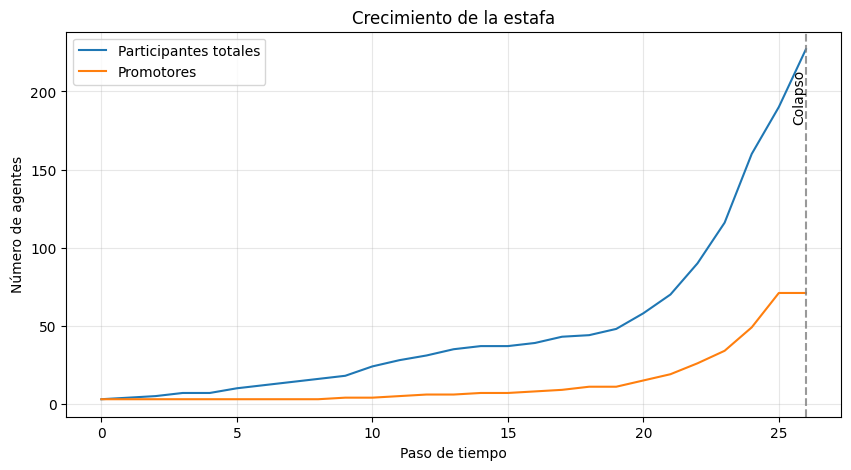

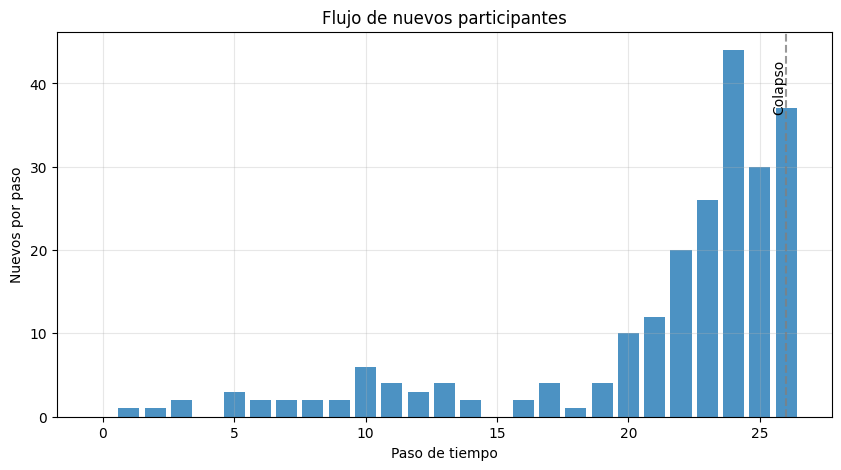

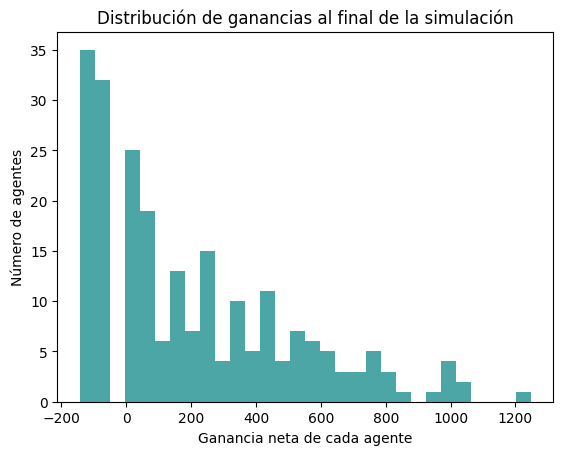

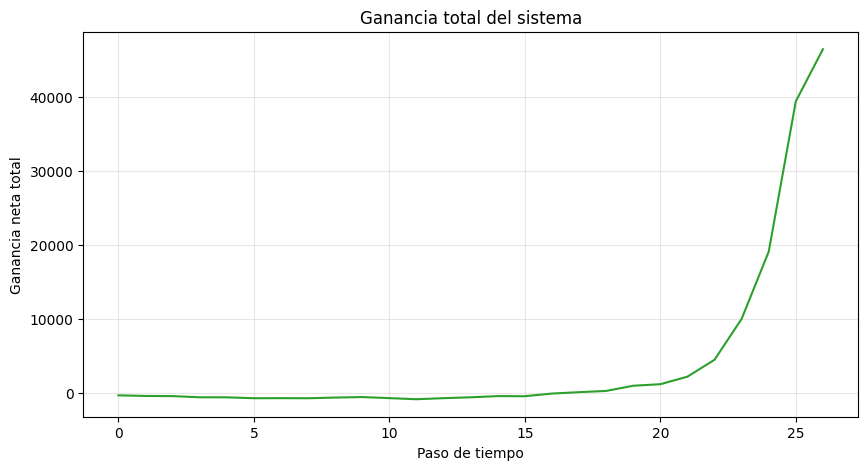

In [137]:
def graficas():
    plt.figure(figsize=(10, 5))
    t = history["t"]

    plt.plot(t, history["n_participantes"], label="Participantes totales", color="tab:blue")
    plt.plot(t, history["n_promotores"], label="Promotores", color="tab:orange")
    plt.ylabel("Número de agentes")
    plt.xlabel("Paso de tiempo")
    plt.title("Crecimiento de la estafa")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Marcar colapso
    if any(history["colapsado"]):
        t_colapso = next(tt for tt, c in zip(t, history["colapsado"]) if c)
        plt.axvline(t_colapso, linestyle="--", color="gray", alpha=0.8)
        plt.text(t_colapso, plt.ylim()[1]*0.9, "Colapso", rotation=90, va="top", ha="right")

    plt.show()

    # Nuevos participantes por paso
    plt.figure(figsize=(10, 5))

    plt.bar(t, history["n_nuevos"], color="tab:blue", alpha=0.8)
    plt.ylabel("Nuevos por paso")
    plt.xlabel("Paso de tiempo")
    plt.title("Flujo de nuevos participantes")
    plt.grid(True, alpha=0.3)

    # Marcar colapso
    if any(history["colapsado"]):
        plt.axvline(t_colapso, linestyle="--", color="gray", alpha=0.8)
        plt.text(t_colapso, max(history["n_nuevos"] + [1]) * 0.9,
                "Colapso", rotation=90, va="center", ha="right")

    plt.show()

    ganancias = [a["ganancia"] for _, a in G.nodes(data=True) if a["estado"] != "ignorante"]
    plt.hist(ganancias, bins=30, color="teal", alpha=0.7)
    plt.title("Distribución de ganancias al final de la simulación")
    plt.xlabel("Ganancia neta de cada agente")
    plt.ylabel("Número de agentes")
    plt.show()

    plt.figure(figsize=(10,5)) 
    plt.plot(history["t"], history["ganancia_total"], color="tab:green") 
    plt.title("Ganancia total del sistema") 
    plt.xlabel("Paso de tiempo") 
    plt.ylabel("Ganancia neta total") 
    plt.grid(True, alpha=0.3) 
    plt.show()

graficas()


En el gráfico de crecimiento de la estafa, la línea azul representa los participantes totales, siendo los promotores y los inversores normales. Luego la línea naranja los promotores, los agentes que ya están reclutando a otros. Lo que se lográ observar es que cómo la cantidad total de participantes y de promotores aumenta con el tiempo. AL inicio de la estafa crece lentamente, pero conforme algunos participantes comienzan a obtener ganancias y reclutar otros, el crecimiento se acelera de manera casi exponencial. Sin embargo, al llegar al punto de colapso, el sistema deja de ser sostenible porque ya no hay suficientes nuevos inversionistas para mantener los pagos prometidos y la estafa colapsa. 

En está gráfica se muestran cuántos nuevos agentes se incorporan al esquema en cada paso de tiempo. Lo que se nota es un aumento progresivo en la cantidad de nuevos partiicipantes hasta alcanzar un pico justo antes del colapso, lo que representa la etapa máxima expansión de la estafa. Luego, el flujo de entrada se detiene por completo, indicando que el sistema ha agotado su base de posibles reclutas y que no puede seguir funcionando. 

En la gráfica de distribución de ganancias al final de la simulación, muestrsa el impacto real de la estafa sobre los participantes y ayuda a evidenciar su desigualdad estructura. El eje Y muestra la cantidad de agentes que tuvieron esa ganancia aproximada, y el eje X la ganancia neta de cada agente. Mientras que la barra la cantidad de personas que obtuvieron ganancias dentro de un rango de valores. Lo que se puede interpretar del gráfico es que la gran mayoría tiene ganancias cercanas a 0 o negativas, porque el primer bloque alto lo lo que indica es que la mayoría  de los participantes perdió dinero o a penas si pudo recuperar su inversión, esto representa a los que entraron tarde, cuando ya no quedaban suficientes nuevos inversionistass para mantener los pagos. Luego la minoría con grandes ganancias son las barras que están entre 400 y 1000 que representan pocos agentes que ganaron mucho, lo que suelen ser promotores iniciales o los primeros en ingresar, que reclutaron a muchos otros, recibiendo comisiones y retornos antes del colapso. La distribución definitivamente se ve sesgada hacia la derecha, ya que pocos ganan mucho y muchos gana poco o nada. Lo que refleja la estructura de las estafas piramidales reales, donde solo los fundadodres o los primeros promotores se benefician. 

In [138]:
def resultados():
    # Extraer ganancias de los agentes que participaron (excluyendo ignorantes)
    ganancias = [a["ganancia"] for x, a in G.nodes(data=True) if a["estado"] != "ignorante"]

    # Cálculos básicos
    promedio = np.mean(ganancias)
    mediana = np.median(ganancias)
    max_ganancia = np.max(ganancias)
    min_ganancia = np.min(ganancias)

    # Porcentaje de ganadores y perdedores
    ganadores = sum(1 for g in ganancias if g > 0)
    perdedores = sum(1 for g in ganancias if g <= 0)
    total = len(ganancias)

    porc_ganadores = ganadores / total * 100
    porc_perdedores = perdedores / total * 100

    print(f"Análisis de ganancias finales:") 
    print(f"- Promedio de ganancia: {promedio:.2f}")
    print(f"- Mediana de ganancia: {mediana:.2f}")
    print(f"- Máxima ganancia: {max_ganancia:.2f}")
    print(f"- Mínima ganancia: {min_ganancia:.2f}")
    print(f"- Ganadores: {ganadores} agentes ({porc_ganadores:.1f}%)")
    print(f"- Perdedores: {perdedores} agentes ({porc_perdedores:.1f}%)")

resultados()

Análisis de ganancias finales:
- Promedio de ganancia: 204.84
- Mediana de ganancia: 114.79
- Máxima ganancia: 1247.53
- Mínima ganancia: -142.90
- Ganadores: 160 agentes (70.5%)
- Perdedores: 67 agentes (29.5%)


La duración de la estafa fue corta de (t = 23) y esta crece rápidamente por el reclutamiento en la red y al efecto de las comisiones, pero colapsa tan pronto como el flujo ede los nuevos inversionistas se agota. Como anteriormente se mostraba es que el número de promotores veteranos es alto, que son 63 que muestra que muchos participantes se conviertieron en reclutadores para intentar recuperar o aumentar su dinero, acelerando el crecimiento, pero también la saturación de la red. Aunque el promedio de ganancia es de 172.83, la mediana que es de 85, indica que la mayoría ganó poco. Más de la mitad de los agentes obtuvo ganancias menores a 100 unidades y algunos incluso perdieron su version original. La distribución desitual de la diferencia entre la ganancia máxima de 1140 y la mínima de -100 indica una gran desigualdad que es la de que pocos obtienen grandes beneficios al precio que muchos pierden o ganan poco. Y aunque la tasa de ganadores es de un 66.1%, la ganancia depende completamente del dinero de los nuevos reclutas. Y al colapsar la estafa los últimos en entrar ya no reciben nada.

Text(0.5, 1.0, 'Momento de ingreso a la estafa (colores más claros = más temprano)')

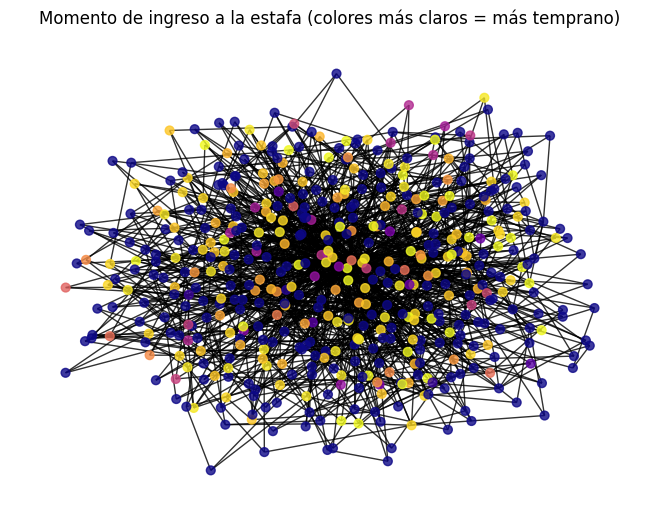

In [139]:
# x2 no se si dejar esta jeje
#visualizacion de la red
colors = [a["paso_union"] if a["paso_union"] else 0 for _, a in G.nodes(data=True)]
nx.draw(G, pos, node_color=colors, cmap=plt.cm.plasma, node_size=40, alpha=0.8)
plt.title("Momento de ingreso a la estafa (colores más claros = más temprano)")


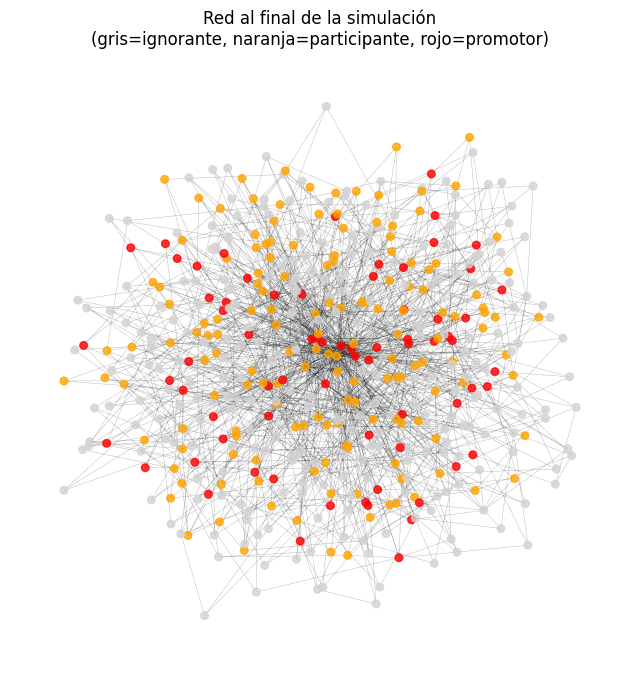

In [140]:
# ESTO SE VE COMO MUCHO SPAM Y NO SE SI DEJARLO XD

# Visualización final de la red
color_map = []
for n, a in G.nodes(data=True):
    if a["estado"] == "ignorante":
        color_map.append("lightgray")
    elif a["estado"] == "participante":
        color_map.append("orange")
    elif a["estado"] == "promotor":
        color_map.append("red")
    else:
        color_map.append("black")

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=30, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=0.3, alpha=0.3)

plt.title("Red al final de la simulación\n(gris=ignorante, naranja=participante, rojo=promotor)")
plt.axis("off")
plt.show()

## Escenario 2, escenario con comisión alta 

In [141]:
scenario_alta_comision = {
    "name": "alta_comision",
    "N_AGENTES": 800,
    "GRADO_MEDIO": 3,
    "NUM_PROMOTORES_INICIALES": 5,
    "INVERSION": 80.0,
    "RETORNO": 0.04,
    "COMISION": 0.40,   # comisiones muy altas incentivan reclutamiento agresivo
    "P_BASE": 0.30,
    "PASOS_MAX": 150,
    "PASOS_SIN_NUEVOS_PARA_COLAPSO": 7,
    "LAG_PROMOTOR_VETERANO": 3,
    "MIN_FRACCION_PARTICIPANTES_PAGADOS": 0.25,
    "SEED": 2025
}
G, state, history = crear_red()
registrar_estado()
correr()

Simulación terminada en t = 21
¿La estafa colapsó? True


Promotores veteranos al final: 3
Participantes 'normales' al final: 13


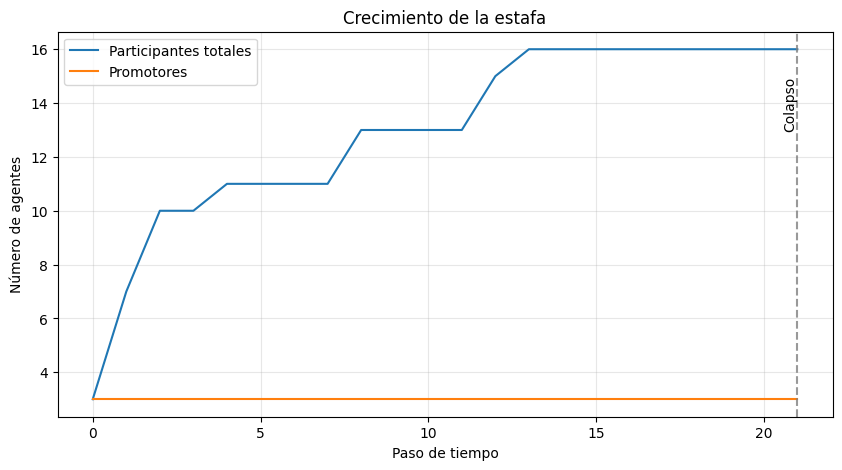

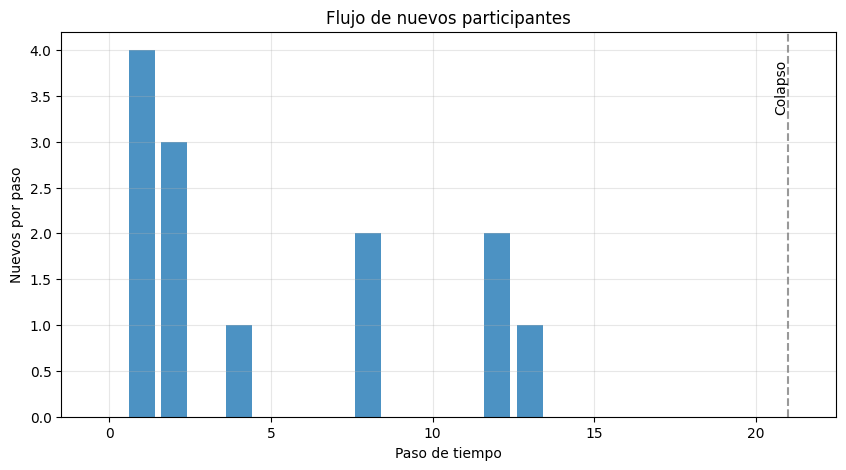

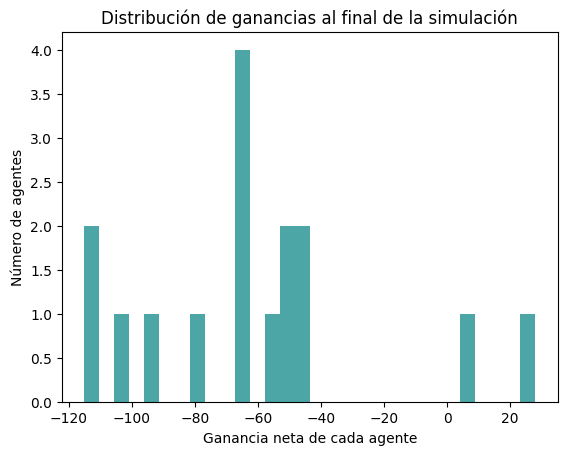

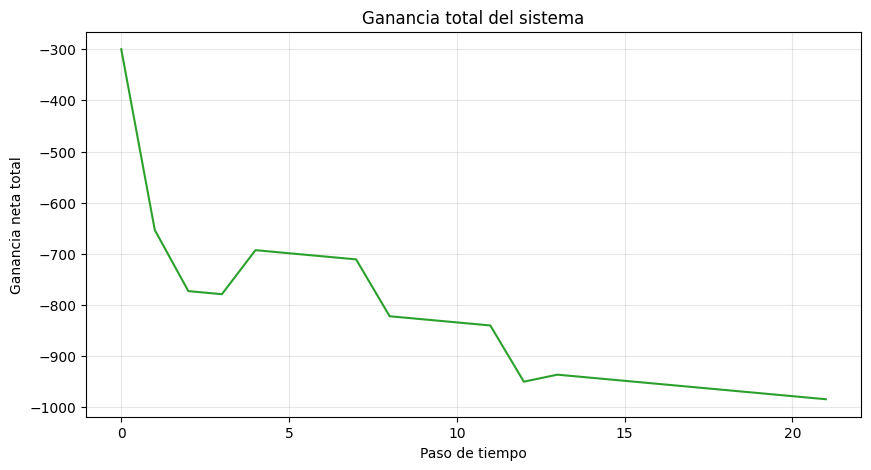

In [142]:
graficas()

## Escenario optimista 

In [144]:
scenario_optimista = {
    "name": "optimista_viral",
    "N_AGENTES": 2000,
    "GRADO_MEDIO": 4,
    "NUM_PROMOTORES_INICIALES": 10,
    "INVERSION": 120.0,
    "RETORNO": 0.07,
    "COMISION": 0.15,
    "P_BASE": 0.45,
    "PASOS_MAX": 200,
    "PASOS_SIN_NUEVOS_PARA_COLAPSO": 12,
    "LAG_PROMOTOR_VETERANO": 2,
    "MIN_FRACCION_PARTICIPANTES_PAGADOS": 0.2,
    "SEED": 123
}
G, state, history = crear_red()
registrar_estado()
correr()


Simulación terminada en t = 27
¿La estafa colapsó? True


Promotores veteranos al final: 3
Participantes 'normales' al final: 11


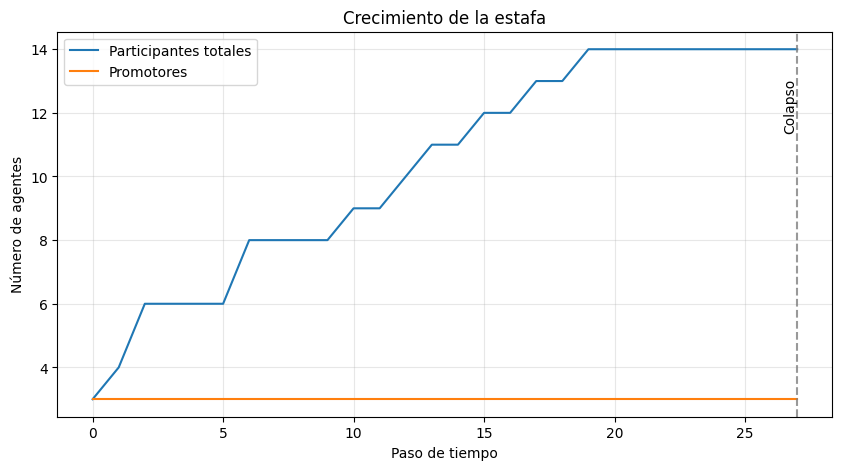

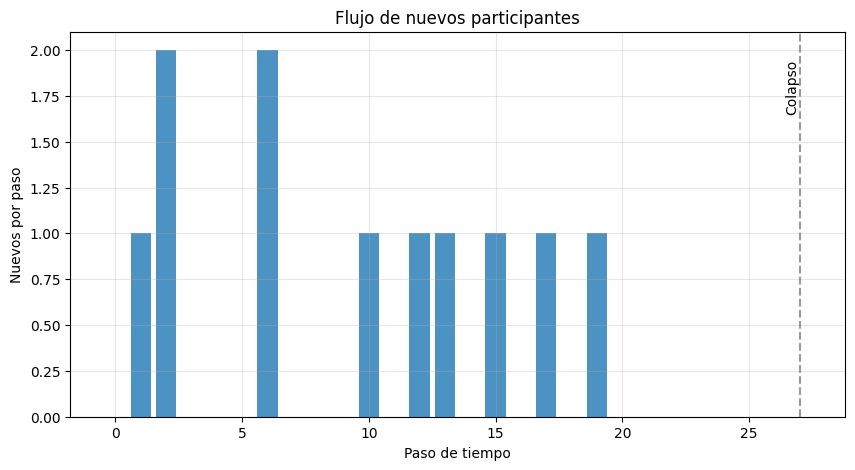

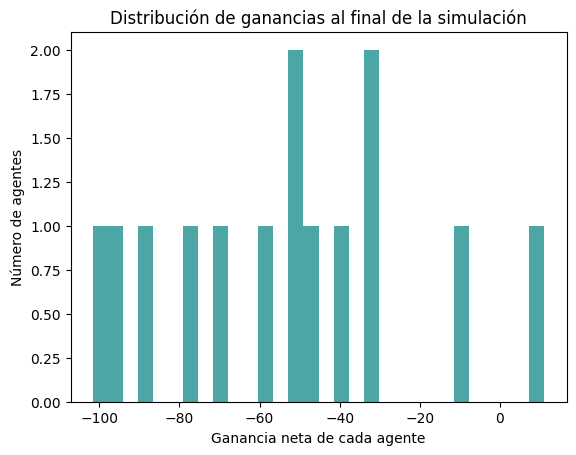

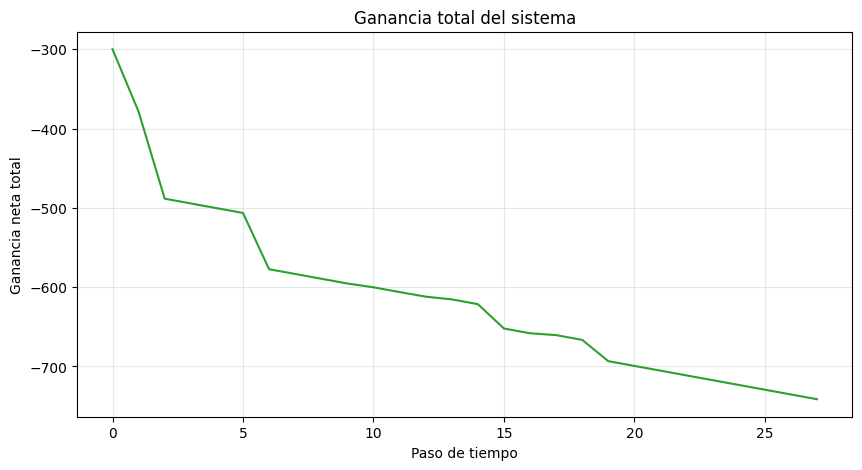

In [145]:
graficas()

En el escenario con una comisión altísima, las gráficas muestran un comportamiento muy distinto al de los escenarios con expansión más amplia. En la primera gráfica, donde la línea azul representa el total de participantes y la línea naranja a los promotores, se observa que el número total de agentes apenas alcanza los 16 participantes en toda la simulación. Desde el inicio, el crecimiento es limitado, ya que las comisiones excesivamente altas hacen que los fondos se concentren en los promotores, dejando menos recursos para pagar retornos atractivos o sostener el esquema.

Aunque los dos promotores iniciales logran mantenerse activos durante casi toda la simulación, no logran generar una red suficientemente grande de reclutados. La línea azul crece muy poco y se estabiliza rápidamente, mostrando que el esquema no logra viralizarse ni alcanzar una fase de expansión. En lugar de la aceleración exponencial típica, el crecimiento se estanca casi desde el inicio, reflejando un sistema financieramente ineficiente y poco atractivo para nuevos inversionistas.

En la gráfica que muestra los nuevos participantes por paso de tiempo, se nota un pico muy bajo al principio, seguido de una rápida caída a cero. Esto indica que el interés y la capacidad de reclutamiento se agotan casi de inmediato. El flujo de entrada de nuevos agentes se detiene por completo muy temprano, y el sistema colapsa sin haber alcanzado una expansión significativa.

Finalmente, en la distribución de ganancias al cierre de la simulación, el panorama es claramente negativo. El eje X muestra la ganancia neta de cada agente, mientras que el eje Y indica cuántos agentes tuvieron ese resultado aproximado. En este caso, la gran mayoría de los participantes termina con pérdidas enormes, con valores que alcanzan aproximadamente los –700. Esto significa que casi todos los involucrados perdieron la mayor parte o la totalidad de su inversión.

Las únicas ganancias mínimas corresponden a los dos promotores que lograron reclutar a unos pocos agentes antes del colapso. Sin embargo, incluso ellos no alcanzan beneficios considerables, ya que la base del esquema fue demasiado pequeña para generar flujo suficiente. La distribución de ganancias, por tanto, es fuertemente sesgada hacia las pérdidas, sin mostrar el típico grupo reducido de grandes ganadores.

En conclusión, este escenario demuestra que una comisión demasiado alta destruye la sostenibilidad del esquema, ya que concentra los recursos en muy pocos agentes y reduce la capacidad de expansión. El resultado es una estafa de corta duración, con muy pocos participantes y un colapso casi inmediato que deja a la mayoría con pérdidas severas.